In [1]:
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.stats import norm
import scipy as sp
from sklearn.mixture import GaussianMixture
import torch
%matplotlib notebook

In [2]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
window_size = 250
pre_filtering_thresh = 0.0
percent = 0.05
means_init = [
              [[0.9, 0.9], [0.1, 0.1]],
              [[0.9, 0.9], [0.1, 0.1]],
              [[0.9, 0.9], [0.1, 0.1]]
             ]

In [4]:
# data = np.load("scores_fg_uc_bg_split_1_1.pkl", allow_pickle=True)
data = np.load("scores.pkl", allow_pickle=True)
df = pd.DataFrame.from_dict(data)
df

ValueError: All arrays must be of the same length

In [5]:
# df = df[df['class_labels'] == 1]

In [6]:
features = df[['iou_roi_pl', 'teacher_pred_scores', 'roi_scores', 'pcv_scores', 'num_points_in_roi', 'class_labels']]
targets = df['iou_roi_gt']
class_labels = df['class_labels']

In [7]:
targets = (targets > 0.70).astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=class_labels, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [8]:
numerical_columns = ["num_points_in_roi"]

preprocessor = ColumnTransformer(
    [
        ("scaler", MinMaxScaler(), numerical_columns),
        ("one_hot", OneHotEncoder(drop="if_binary"), ['class_labels']),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)


model = make_pipeline(
    preprocessor,
    LogisticRegression(C=0.01, penalty="l1", solver="saga", tol=0.0001)
)
_ = model.fit(X_train, y_train)

clf = model[-1]


<IPython.core.display.Javascript object>


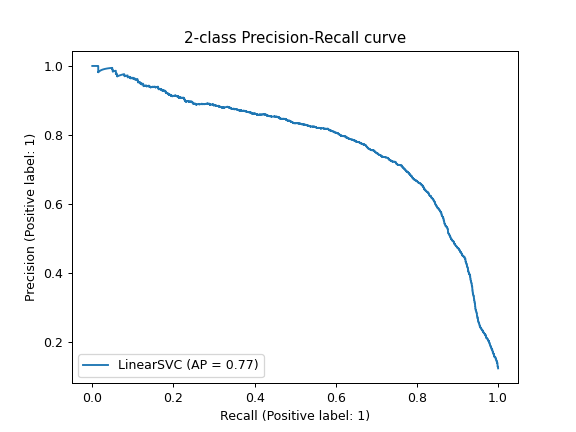

In [9]:
y_score = model.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [12]:
clf.coef_

array([[ 7.42800009e-01,  8.45007471e-06, -1.13581113e+00,
         0.00000000e+00,  5.28872495e+00,  3.16254297e+00,
         1.85373363e+00,  0.00000000e+00]])

In [11]:
sparsity = np.mean(clf.coef_ == 0) * 100
score = model.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 25.00%
Test score with L1 penalty: 0.9339


<IPython.core.display.Javascript object>


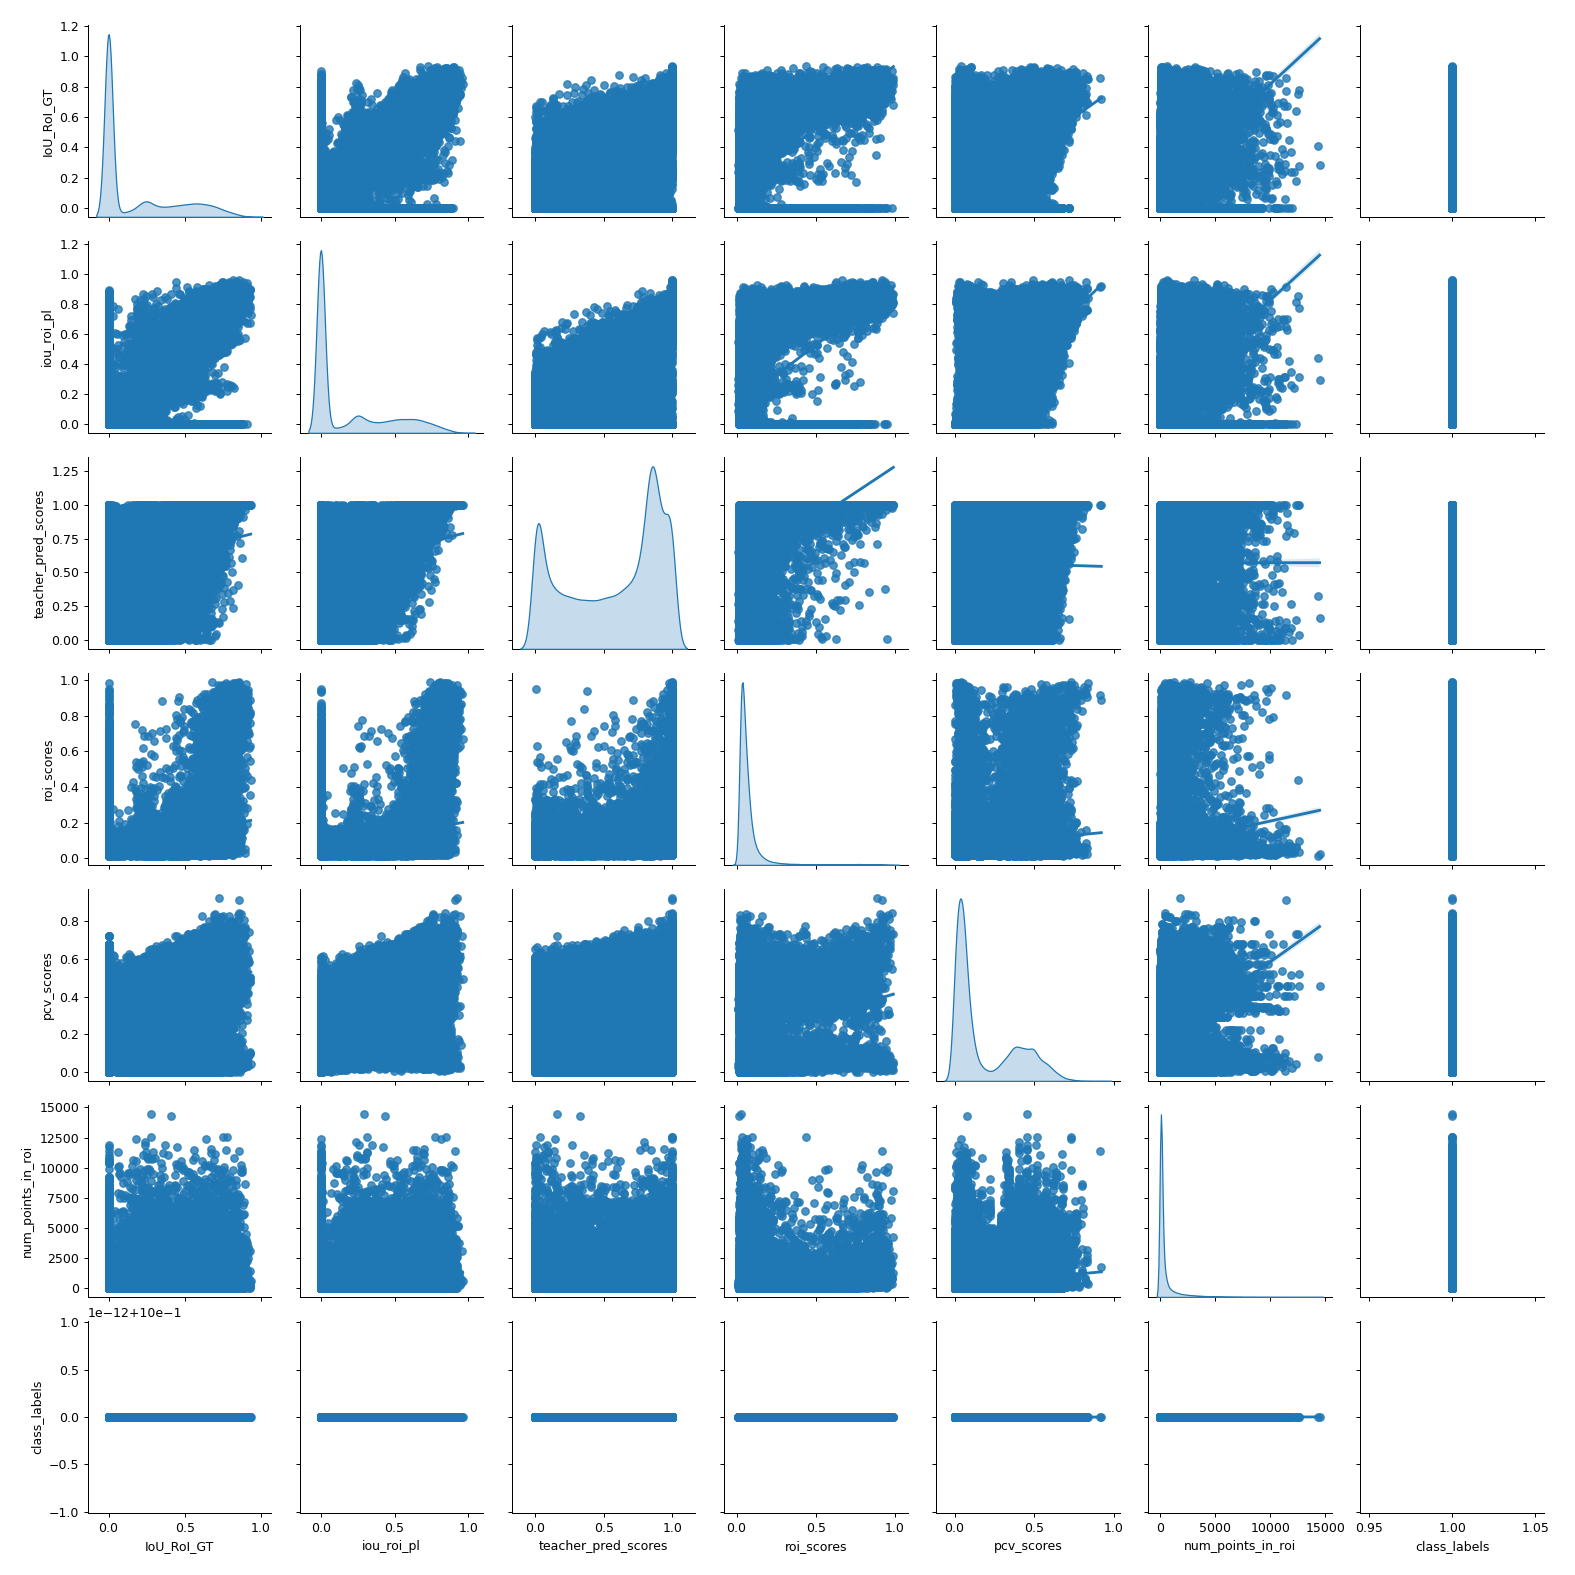

/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [30]:
train_dataset = X_train.copy()
train_dataset.insert(0, "IoU_RoI_GT", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [9]:
# categorical_columns = ["class_labels"]
numerical_columns = ["num_points_in_roi"]

preprocessor = ColumnTransformer(
    [
        ("scaler", MinMaxScaler(), numerical_columns),
#         ("one_hot", OneHotEncoder(drop="if_binary"), categorical_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)


model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(regressor=Ridge(alpha=1e-10))
)
X_out = model.fit(X_train, y_train)
# X_out = preprocessor.fit_transform(X_train)


<IPython.core.display.Javascript object>


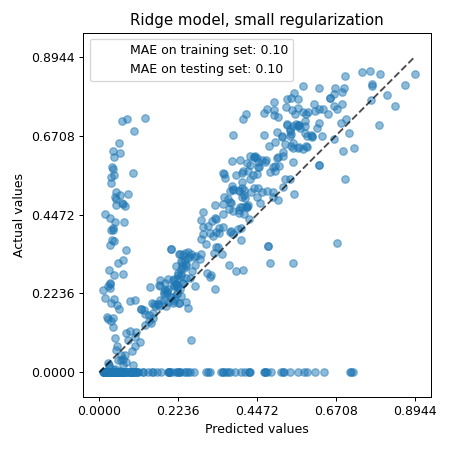

In [10]:
mae_train = mean_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
scores = {
    "MAE on training set": f"{mae_train:.2f}",
    "MAE on testing set": f"{mae_test:.2f}",
}
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [11]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
num_points_in_roi,0.256260
iou_roi_pl,0.664230
teacher_pred_scores,0.022247
roi_scores,0.256558
pcv_scores,0.038564


<IPython.core.display.Javascript object>


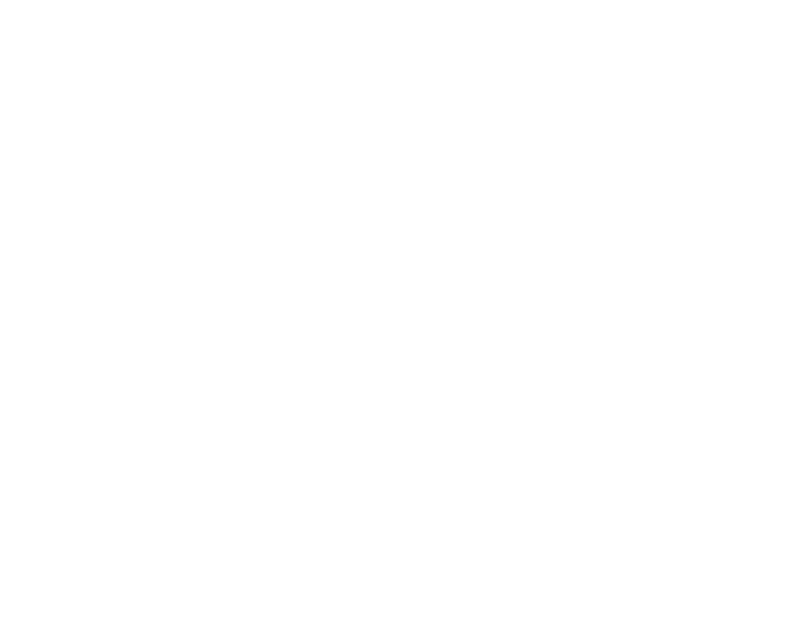

<IPython.core.display.Javascript object>


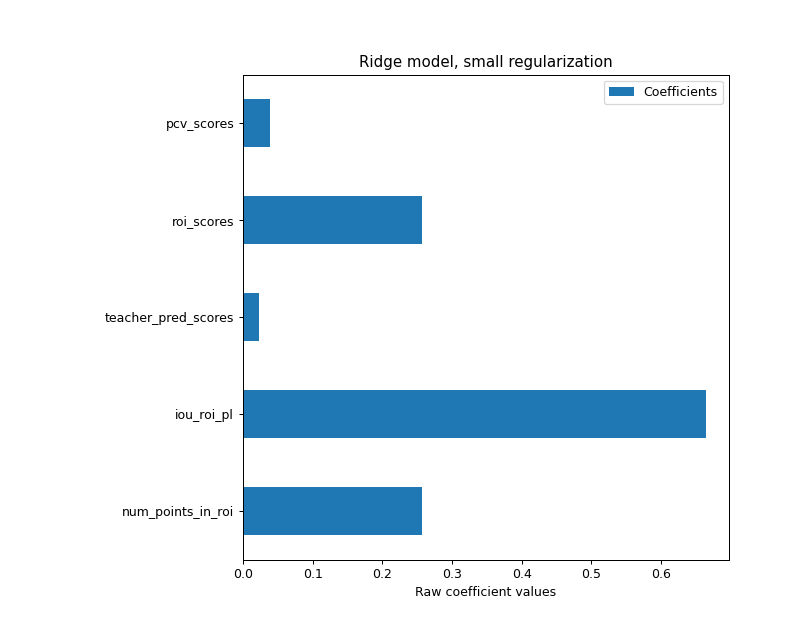

In [12]:
plt.figure(figsize=(9, 7))
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

<IPython.core.display.Javascript object>


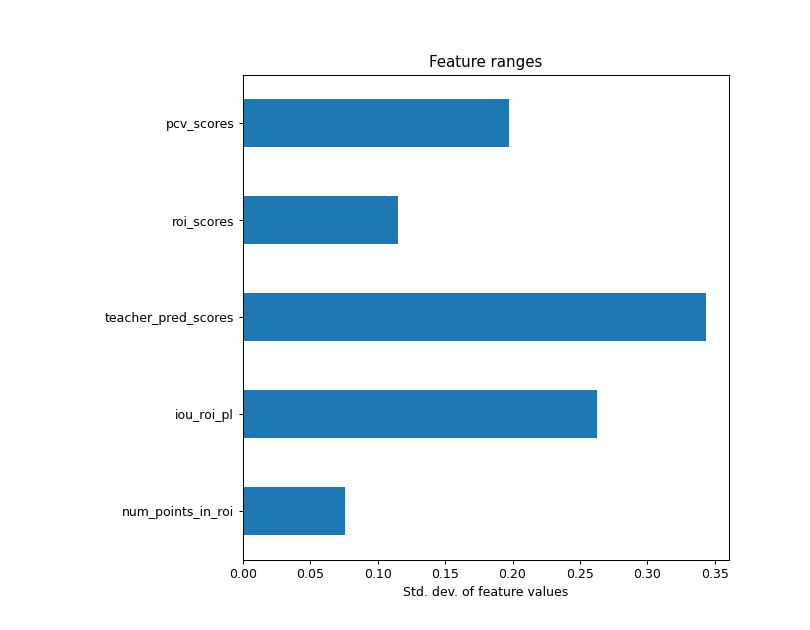

In [13]:
plt.figure(figsize=(9, 7))
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

<IPython.core.display.Javascript object>


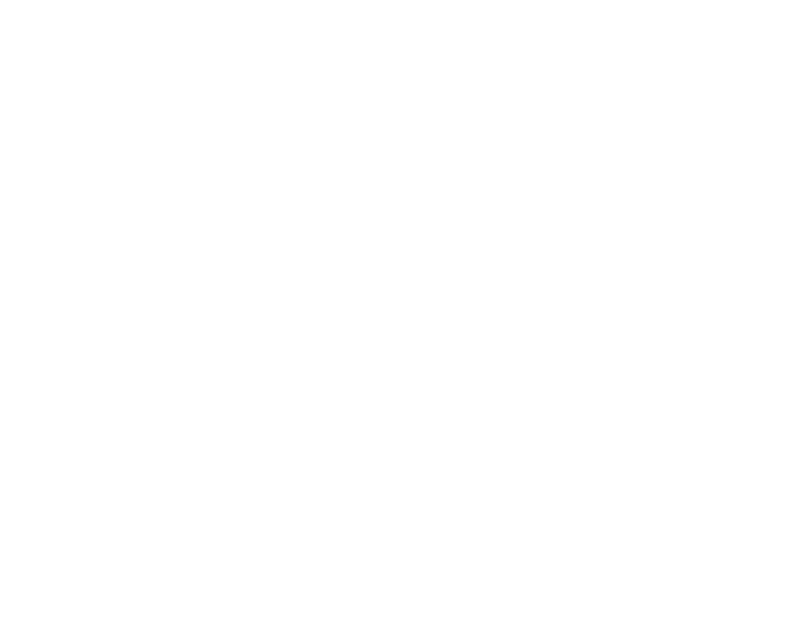

<IPython.core.display.Javascript object>


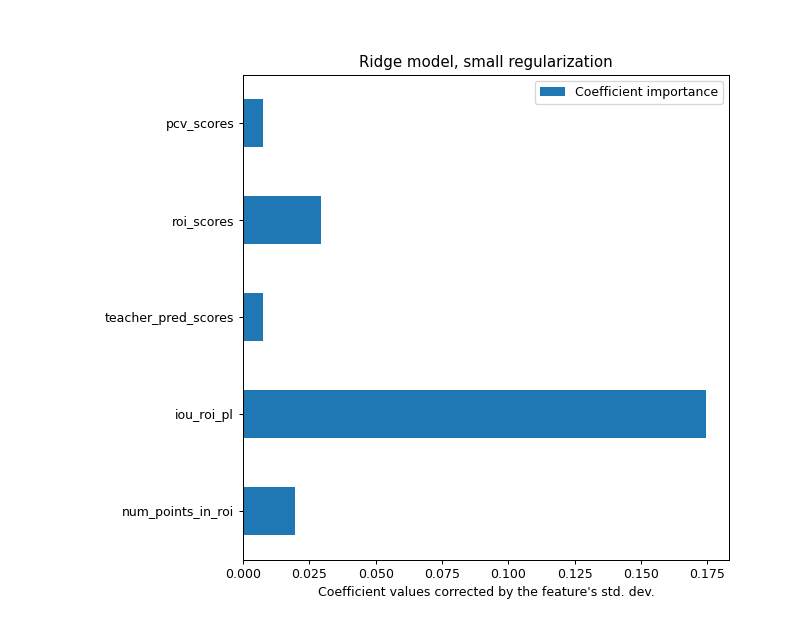

In [14]:
plt.figure(figsize=(9, 7))
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [15]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=8,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_train, y_train))
    ],
    columns=feature_names,
)

<IPython.core.display.Javascript object>


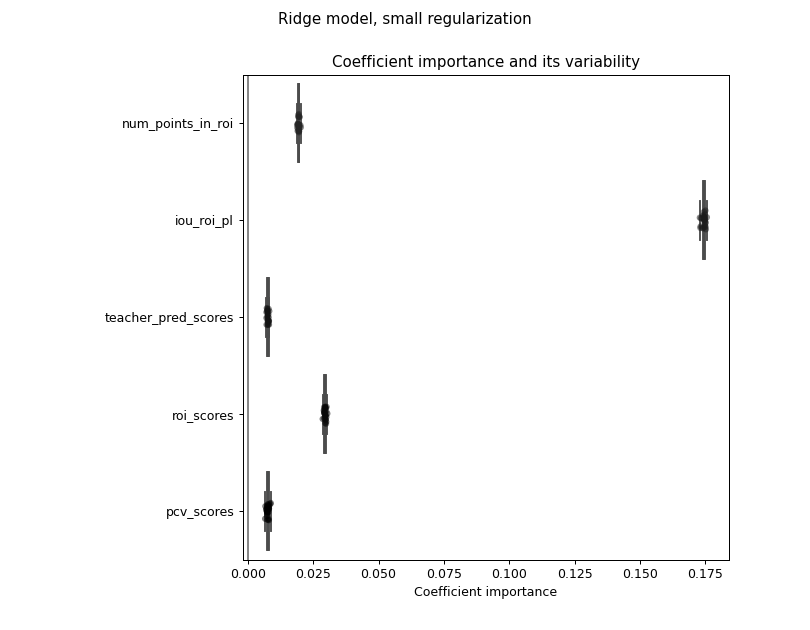

/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [16]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

In [17]:
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
preprocessor = ColumnTransformer(
    [
        ("scaler", MinMaxScaler(), numerical_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=300_000)
    ),
)

_ = model.fit(X_train, y_train)

In [18]:
model[-1].regressor_.alpha_

1e-06

<IPython.core.display.Javascript object>


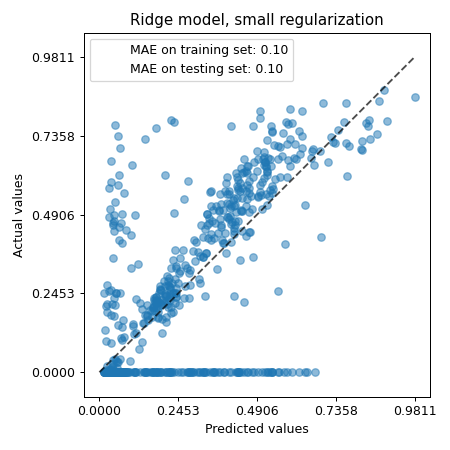

In [19]:
mae_train = mean_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
scores = {
    "MAE on training set": f"{mae_train:.2f}",
    "MAE on testing set": f"{mae_test:.2f}",
}
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

<IPython.core.display.Javascript object>


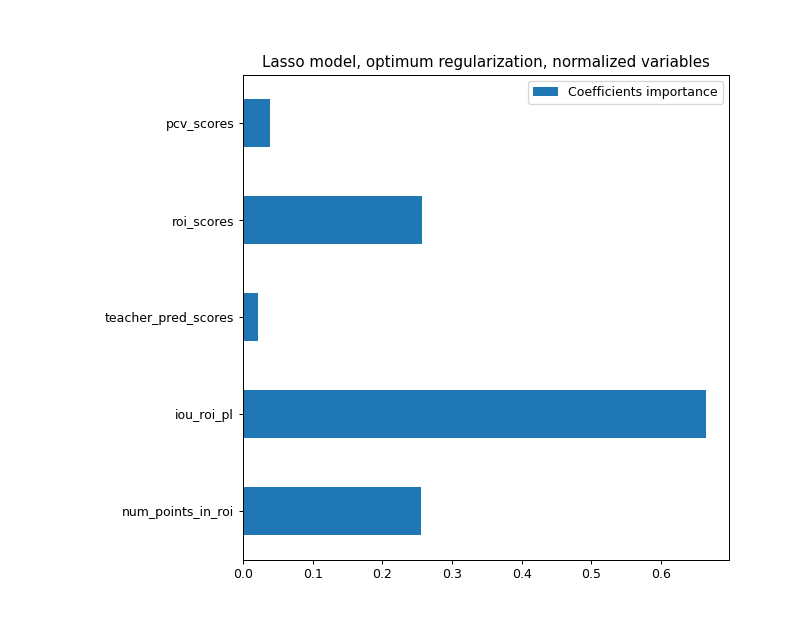

In [20]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [21]:
cv_model = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

<IPython.core.display.Javascript object>


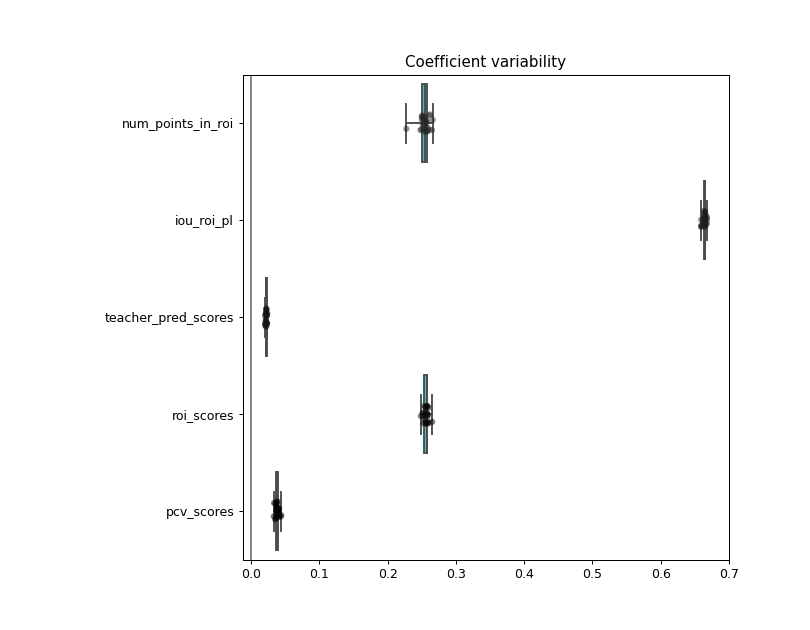

/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [22]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

In [23]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=4, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=4, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [24]:
# fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# classwise_threshs_comp1_lower = [[] for _ in range(3)]
# classwise_threshs_comp1_upper = [[] for _ in range(3)]
# classwise_threshs_comp2_lower = [[] for _ in range(3)]
# classwise_threshs_comp2_upper = [[] for _ in range(3)]

# max_iter = int(df['iteration'].max())
# all_labels = [[] for _ in range(3)]
# for cls in range(3):
#     # Fit a Gaussian and draw densities
#     for step, i in enumerate(range(0, max_iter, window_size)):
#         iter_mask = (i <= df['iteration']) & (df['iteration'] < i + window_size)
#         cls_mask = df['class_labels'] == cls+1
#         filter_mask = pre_filtering_thresh < df['iou_roi_pl']
#         mask = iter_mask & cls_mask & filter_mask
# #         mask = iter_mask & cls_mask
                     
#         roi_ious_pl = df[mask]['iou_roi_pl']
#         scores = df[mask]['pred_scores'].values
#         scores = torch.sigmoid(torch.tensor(scores)).cpu().numpy().reshape(-1, 1)
#         iterations = df[mask]['iteration']
        
#         x = np.concatenate([roi_ious_pl.values.reshape(-1, 1), scores], axis=1)
        
#         gm = GaussianMixture(n_components=2, means_init=means_init[cls])
#         gm.fit(x)
#         labels = gm.predict(x)
#         all_labels[cls].append(labels)
#         axes[0][cls].scatter(iterations.astype(int), roi_ious_pl, s=0.1, alpha=0.5, c=labels)
        
# #         mu, sigma = norm.fit(roi_ious_pl)
# #         lower_bound_iou_comp1 = norm.ppf(percent, loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0]))
# #         upper_bound_iou_comp1 = norm.ppf(1 - percent, loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0]))
        
# #         lower_bound_iou_comp2 = norm.ppf(percent, loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1]))
# #         upper_bound_iou_comp2 = norm.ppf(1 - percent, loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1]))
        
# #         classwise_threshs_comp1_lower[cls].append(lower_bound_iou_comp1.item())
# #         classwise_threshs_comp1_upper[cls].append(upper_bound_iou_comp1.item())
        
# #         classwise_threshs_comp2_lower[cls].append(lower_bound_iou_comp2.item())
# #         classwise_threshs_comp2_upper[cls].append(upper_bound_iou_comp2.item())
        
# #         x = np.linspace(0, 1, 100)
# #         comp1_pdf = norm.pdf(x, gm.means_[0], np.sqrt(gm.covariances_[0]))
# #         comp2_pdf = norm.pdf(x, gm.means_[1], np.sqrt(gm.covariances_[1]))
# #         width = step * 0.3 + 0.2
# #         axes[1][cls].plot(x, comp1_pdf.reshape(-1), 'k', linewidth=width, alpha=0.5, color='orange')
# #         axes[1][cls].plot(x, comp2_pdf.reshape(-1), 'k', linewidth=width, alpha=0.5, color='black')

        
# # for cls in range(3):
# #     x = range(0, max_iter, window_size)
# #     axes[0][cls].plot(x, classwise_threshs_comp1_lower[cls], c='blue')
# #     axes[0][cls].plot(x, classwise_threshs_comp1_upper[cls], c='blue')
    
# #     axes[0][cls].plot(x, classwise_threshs_comp2_lower[cls], c='red')
# #     axes[0][cls].plot(x, classwise_threshs_comp2_upper[cls], c='red')
    
# # fig.tight_layout()

In [25]:
# classwise_labels = []
# for cls in range(3):
#     classwise_labels.append(np.concatenate(all_labels[cls]))

# df['fg_bg_label'] = -1

# for cls in range(3):
#     cls_mask = df['class_labels'] == cls + 1
#     filter_mask = pre_filtering_thresh < df['iou_roi_pl']
#     mask = cls_mask & filter_mask
#     df.loc[mask, 'fg_bg_label'] = classwise_labels[cls]